In [15]:
import random 
import os
import pandas as pd 
import numpy as np 
import glob
import duckdb
import geopandas as gpd 
from scipy.stats import ranksums
from sklearn.linear_model import LogisticRegression,LinearRegression,Lasso
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import matplotlib.pyplot as plt
import requests

from dbfread import DBF

class DataLoader: 

    ZCTA_geo_datapath = '../datasets/State-zip-code-GeoJSON/*.json'
    claims_data_path='../datasets/Flood-insurance/FimaNfipClaims.csv'
    zillow_data_path='../datasets/Zillow-home-prices/zillow_realestate_ts_zip.csv'
    irs_data_path='../datasets/Demographics/19irs.csv'
    zip_geos_pd='json_to_dfs_no_geom'

    FRED_api_endpoint = 'https://api.stlouisfed.org/fred/series/observations'
    FRED_api_key = '8fd9759bac0caf671d3462eed0b34d68'

    DUCKDB_location = '../datasets/combined_data.db'
    
    def __init__(self): 
        try:
            self.con = self.initialize_ddb()
        except Exception as e: 
            print(e) 
            pass 

    def retrieve_regional_data_snapshot(self, region_str, time_window_size=2):
        
        assert hasattr(self, 'con') 

        yr_upper_bound = 2020 #look at pre-covid
        yr_lower_bound = yr_upper_bound - time_window_size

        df = self.con.sql(f"select * from zillow_home_prices where Metro ilike '%{region_str}%'").df()
        cols = ['RegionName', 'Metro','CountyName'] + \
            [
                i for i in df.columns 
                if len(i.split('-')) == 3 
                    and int(i.split('-')[0]) < yr_upper_bound
                    and int(i.split('-')[0]) >= yr_lower_bound
        ]
        zillow_df = df[cols]
        zillow_df = zillow_df.rename(
            columns={
                'RegionName':'zip'
            }
        )
        
        zip_codes = zillow_df['zip'].unique()

        zips_str = ','.join(zip_codes)
        irs_df = self.con.sql(f'select * from irs_zip where zip in ({zips_str})').df()
        claims_df = self.con.sql(
            f'''
             select * 
             from (select * from nfip_claims_zip where zip in ({zips_str})) nfip
             inner join zip_geos using (zip)
             where dateOfLoss between '{yr_lower_bound}-01-01' and '{yr_upper_bound}-01-01'
             order by dateOfLoss
             ;
             '''
        ).df()

        return {
            'ZILLOW' : zillow_df, 
            'IRS_SOCIO': irs_df, 
            'NFIP_CLAIMS': claims_df
        }
    
    def retrieve_geo_attr(self, state):
        dbf = DBF(f'../datasets/State-zip-code-GeoJSON/{state}_distance.DBF')
        return pd.DataFrame(dbf)[['ZCTA5CE20','NEAR_DIST']].rename(columns={'ZCTA5CE20':'zip'}).set_index('zip')

    def retrieve_macroeconomic_data(self):

        if hasattr(self, 'macro_data'):
            return self.macro_data 
            
        econ_dataset_codes = {
            'fed_funding_rate':'DFF', 
            '30yr_mortgage_avg':'MORTGAGE30US', 
            '15yr_mortgage_avg':'MORTGAGE15US',  
            'consumer_price_idx':'CPIAUCSL', 
            'real_disposable_income':'DSPIC96', 
            'real_disp_income_per_capita':'A229RX0'
        }

        data=[]
        for col, code in econ_dataset_codes.items(): 
            params = {
                'series_id': code, 'api_key': self.FRED_api_key, 'file_type': 'json'
            }
            try: 
                resp = requests.get(self.FRED_api_endpoint, params=params).json()
                resp_df = pd.DataFrame(resp['observations'])\
                    .drop(columns=['realtime_start','realtime_end'])\
                    .rename(columns={'value':col})
                resp_df[col] = resp_df[col].astype(float)
                resp_df['date'] = pd.to_datetime(resp_df['date'])
                resp_df['year'] = resp_df['date'].dt.year
                resp_df['month'] = resp_df['date'].dt.month 
                resp_df_monthly = resp_df\
                    .drop(columns=['date'])\
                    .groupby(['year','month'])[[col]].mean()
            
                data.append(resp_df_monthly)
            except Exception as e: 
                print(e)
                continue
                        
        cct = pd.concat(data,axis=1)\
            .sort_values(by=['year','month'])\
            .reset_index()
        cct['date'] = cct['year'].astype(str) + '-' + cct['month'].astype(str) 
        cct['date'] = pd.to_datetime(cct['date']) 
        cct = cct.set_index('date')
        self.macro_data = cct
        return cct
    
        
    def initialize_ddb(self):
        
        if os.path.exists(self.DUCKDB_location): 
            return duckdb.connect(self.DUCKDB_location)
            
        base_query = '''
        drop table if exists nfip_claims
        ;

        create table nfip_claims as 
        select  
            id,
            asOfDate, 
            dateOfLoss,
            policyCount as insuredUnits, 
            baseFloodElevation, 
            ratedFloodZone, 
            occupancyType, 
            originalConstructionDate, 
            originalNBDate, 
            coalesce(amountPaidOnBuildingClaim,0) +                  
            coalesce(amountPaidOnContentsClaim,0) +                  
            coalesce(amountPaidOnIncreasedCostOfComplianceClaim,0) as totalClaim, 
            coalesce(totalBuildingInsuranceCoverage,0) + 
            coalesce(totalContentsInsuranceCoverage,0) as totalCovered, 
            coalesce(buildingDamageAmount,0) + coalesce(contentsDamageAmount,0) as totalDamageLoss, 
            buildingDeductibleCode, 
            contentsDeductibleCode,
            causeOfDamage, 
            buildingPropertyValue, 
            floodproofedIndicator, 
            floodEvent, 
            state, 
            reportedZipCode, 
            censusTract, 
            latitude, 
            longitude
        from read_csv('{claims_data_path}', strict_mode=False)
        ;

        drop table if exists nfip_claims_zip 
        ; 

        create table nfip_claims_zip as 
        select 
            reportedZipCode as zip, 
            state,
            floodEvent,
            dateOfLoss,
            count(id) as claimCounts,
            sum(insuredUnits) as policyCounts, 
            sum(totalClaim) as totalClaimZip, 
            sum(totalDamageLoss) as totalLossesZip
        from nfip_claims
        group by 1,2,3,4
        order by 5 desc
        ;

        drop table if exists irs_zip
        ;

        create table irs_zip as 
        select 
            STATE, 
            ZIPCODE as zip, 
            AGI_STUB as adjGrossIncomeTaxBracket,
            N1 as numberTaxReturns, 
            MARS1 as singleStatusTotalReturns, 
            MARS2 as marriedStatusTotalReturns, 
            MARS4 as HoHTotalReturns, 
            N2 as totalIndividuals,
            VITA as volunteerAssistedReturns, 
            ELDERLY as elderlyReturns, 
            A00100 as adjustedGrossIncome, 
            A02650 as totalIncome, 
            N00200 as returnsTotalwSalariesWages, 
            N00300 as returnsTotalTaxableInterest, 
            A00300 as taxableInterestAmt,
            SCHF   as returnsTotalFarm, 
            A18450 as stateLocalSalesTaxTotal, 
            N18500 as realEstateTaxTotal, 
            N18800 as returnsTotalPersonalPropertyTax, 
            A18800 as propertyTaxAmtTotal, 
            N19300 as returnsTotalMortgageInterestPaid, 
            A19300 as mortgageInterestPaidTotal,
            N07225 as returnsDependentCareCredit, 
            A07225 as dependentCareCreditTotal, 
            N07230 as returnsEducationCredit, 
            A07230 as educationCreditTotal, 
            N85770 as returnsPremiumsCredit, ---aids in offsetting health insurance premiums
            A85770 as premiumsCreditTotal, 
        from read_csv('{irs_data_path}', strict_mode=False)
        ;
    
        drop table if exists zillow_home_prices
        ;

        create table zillow_home_prices as 
        select * 
        from read_csv('{zillow_data_path}', strict_mode=False)
        ;

        drop table if exists zip_geos
        ;

        create table zip_geos as 
        select * 
        from {zip_geos_pd}
        ;
        '''

        read_jsons = [
            gpd.read_file(gj)[['ZCTA5CE10','geometry','ALAND10','AWATER10']] 
            for gj in glob.glob(self.ZCTA_geo_datapath)
        ]
        json_to_dfs = pd.concat(read_jsons)
        json_to_dfs = json_to_dfs.rename(
                columns={
                    'ZCTA5CE10':'zip', 
                    'ALAND10':'landAreaTotal', 
                    'AWATER10':'waterAreaTotal'
                }
            )
        con = duckdb.connect(self.DUCKDB_location)
        con.sql(
            base_query.format(
                claims_data_path=self.claims_data_path,
                zillow_data_path=self.zillow_data_path, 
                irs_data_path=self.irs_data_path, 
                zip_geos_pd=self.zip_geos_pd
            )
        )
        return con
    
class CausalAnalysis: 
    
    def __init__(self, dataloader, state, time_window): 
        
        self.dataloader = dataloader
        self.state = state #f', {state}'
        self.n = time_window

         #find a better way to do this...prevents db locking from occurring
        if not hasattr(self.dataloader, 'con'):
            self.dataloader.initialize_ddb()
        else: 
            self.dataloader.con = duckdb.connect(self.dataloader.DUCKDB_location)
    
        datasets = self.dataloader.retrieve_regional_data_snapshot(f', {state}', time_window_size=self.n)
        self.dataloader.con.close()
        for n, df in datasets.items():
            print(f'Instantiating dataset {n} into memory')
            setattr(self, n, df)

        self.macroeconomic_indicators = dataloader.retrieve_macroeconomic_data() 

    def generate_real_estate_shiftindex(self, historical_discount_factor=None):
        data_hp = self.ZILLOW.set_index('zip').drop(columns=['Metro','CountyName']).T.bfill()

        data_hp['year'] = [int(i.split('-')[0]) for i in data_hp.index]
        data_grp_yr = data_hp.groupby(['year']).mean()

        cpi = self.macroeconomic_indicators\
                 .loc[self.macroeconomic_indicators['year'].between(data_hp['year'].min(),data_hp['year'].max())][['consumer_price_idx']]\
                 .dropna()\
                 .iloc[1:-1,:]

        cpi['year'] = [i.year for i in cpi.index]

        cpi_grp = cpi.groupby(['year']).mean()
        cpi_idx = cpi_grp.iloc[0]/cpi_grp
        cpi_corrected = data_grp_yr.mul(cpi_idx['consumer_price_idx'].to_numpy(),axis=0)

        return ((cpi_corrected.iloc[-1]/cpi_corrected.iloc[0])-1)*100
    
    ### build predictor variable
    def generate_real_estate_shiftindex2(self, historical_discount_factor=0.0005):
        
        def weighting_fn(df, alpha):
            df = df.bfill()
            N=len(df)
            w = np.array([(1-alpha)**i for i in range(N)][::-1]) 
            w_norm = w/w.sum() 
            v = 1e3*(df.T@w_norm)
            return v
        
       # cpi = self.macroeconomic_indicators\
        #          .loc[self.macroeconomic_indicators['year']>=2000][['consumer_price_idx']]\
         #         .dropna()\
          #        .iloc[1:-1,:]

      #  cpi['inflation_correction'] = cpi['consumer_price_idx'].iloc[0] / cpi['consumer_price_idx'] 
            
        ts=self.ZILLOW.bfill().set_index('zip').drop(columns=['Metro','CountyName']).T
      #  ts = ts.mul(cpi['inflation_correction'].to_numpy(),axis=0)
      
        ts_roc = ts.diff().div(ts)
        ts_roc_qtr_smoothed = ts_roc.rolling(4).mean()
   
        return weighting_fn(ts_roc_qtr_smoothed, historical_discount_factor)

    ### build treatment + confounder vars
    def build_features(self):

        socioeconomic_tax_confounders = self.IRS_SOCIO.copy()
        num_rets_feats = [
            'numberTaxReturns',
            'elderlyReturns', 
            'returnsTotalwSalariesWages',
            'returnsDependentCareCredit', 
            'returnsEducationCredit'
        ] 
        piv=socioeconomic_tax_confounders.pivot(
            index='zip', columns='adjGrossIncomeTaxBracket', values='numberTaxReturns'
        )
        piv_norm = piv.div(piv.sum(axis=1),axis=0)
        grp = socioeconomic_tax_confounders.groupby('zip')[num_rets_feats].sum()
        grp = grp.div(grp['numberTaxReturns'],axis=0).drop(columns=['numberTaxReturns'])

        feature_matrix = pd.concat((piv_norm,grp),axis=1)

        risk_variables = self.NFIP_CLAIMS.copy()

        risk_variables['waterAreaProp'] = risk_variables['waterAreaTotal'] / (risk_variables['landAreaTotal']+risk_variables['waterAreaTotal'])
        zip_ = \
            risk_variables.groupby(['zip']).agg(
                numberEvents=pd.NamedAgg(column='floodEvent',aggfunc='count'), 
                totalClaims=pd.NamedAgg(column='totalClaimZip',aggfunc='sum'), 
                totalClaimCounts=pd.NamedAgg(column='claimCounts',aggfunc='sum'),
                totalLosses=pd.NamedAgg(column='totalLossesZip',aggfunc='sum'), 
                waterAreaProp=pd.NamedAgg(column='waterAreaProp',aggfunc='max')
        )

        zip_['log(totalClaims)'] = np.log(zip_['totalClaims']+0.000001) 
        zip_['log(totalLosses)'] = np.log(zip_['totalLosses']+0.000001) 
        
        zip_ = zip_.drop(columns=['totalClaims','totalLosses']) 

        rfs = [
            'numberEvents', 
            'totalClaimCounts',
            'log(totalLosses)', 
        ]

        rf_matrix = zip_[rfs].values
        
        rf_matrix_st = StandardScaler().fit_transform(rf_matrix).mean(axis=1)
        zip_['risk_score'] = rf_matrix_st
        zip_['risk_group'] = rf_matrix_st > rf_matrix_st.mean()
        self.RISK_VARIABLES = zip_
        self.FEATURES = pd.concat((feature_matrix, zip_[['risk_group']]),axis=1).dropna()
        
        return self.FEATURES

    def calculate_propensity_scores(self, plot=False): 

        assert hasattr(self, 'FEATURES')
        prop_score_lr = LogisticRegression() 

        X = self.FEATURES.iloc[:,:-1].values
        y = self.FEATURES['risk_group'].astype(bool)

        prop_score_lr.fit(X,y) 
        self.FEATURES['propensity_score'] = prop_score_lr.predict_proba(X)[:,1]

        if plot: 
            self.FEATURES.loc[self.FEATURES['risk_group']]['propensity_score'].hist(alpha=0.5,label='risky',bins=25)
            self.FEATURES.loc[self.FEATURES['risk_group']==False]['propensity_score'].hist(alpha=0.5,label='non-risky',bins=25)
            plt.title('Propensity Score Distributions')
            plt.legend()
            plt.show()

        return prop_score_lr, self.FEATURES

    def build_matching_groups(self):

        self.calculate_propensity_scores() 

        #idk find a better way to do this, use a mathematical optimization approach? find lit. on this
        COVERED = set()
        def search_closest_match(output_idx_lst, df=self.FEATURES):
            for i in output_idx_lst[1:]:
        
                r = df.iloc[i]
                zip = r.name
        
                if r['risk_group']:
                    if zip in COVERED:
                        continue 
                    else:
                        COVERED.add(zip)
                        return zip

        dataset_match = self.FEATURES.loc[self.FEATURES['risk_group']==False][['propensity_score']]
        prop_score = self.FEATURES['propensity_score'].to_numpy().reshape(-1,1)

        nn = NearestNeighbors(n_neighbors=5, radius=0.25) 
        nn.fit(prop_score)

        control = dataset_match['propensity_score'].to_numpy().reshape(-1,1)
        _, nearest_i = nn.kneighbors(control)

        zip_matched = [
            search_closest_match(i) for i in nearest_i
        ]
        dataset_match['matched_zip_risky'] = zip_matched

        dataset_match = \
        dataset_match\
            .reset_index()\
            .drop(columns=['propensity_score'])\
            .rename(
                columns={
                    'zip':'matched_zip_nonrisky'
                }
        )

        dataset_match = dataset_match.dropna()
   
        return dataset_match

    def build_treatment_effect_report(self, discount_factor, plot=False):
        
        self.matched_zips = self.build_matching_groups() 
        self.home_pr_indices = self.generate_real_estate_shiftindex(
            historical_discount_factor=discount_factor
        )

        def search_index(zip, s=self.home_pr_indices):
            return s.loc[zip]
        
        self.matched_zips['idx_nonrisky'] = self.matched_zips['matched_zip_nonrisky'].apply(search_index)
        self.matched_zips['idx_risky'] = self.matched_zips['matched_zip_risky'].apply(search_index)
        self.matched_zips['idx_diff'] = self.matched_zips['idx_risky']-self.matched_zips['idx_nonrisky']
        if plot: 
            self.matched_zips['idx_nonrisky'].hist(bins=50, alpha=0.5, label='Non-risky Price Shift Index')
            self.matched_zips['idx_risky'].hist(bins=50, alpha=0.5, label='Risky Price Shift Index')
            plt.title('Price Shifts by Zip-code Groups')
            plt.legend()
            plt.show()
            
        test_sig = ranksums(self.matched_zips['idx_nonrisky'],self.matched_zips['idx_risky'])
        
        diffs = self.matched_zips['idx_diff']
        bootstrapped_sample_dist = pd.Series([diffs.sample(n=len(diffs), replace=True).mean() for _ in np.arange(10000)])
        obs = self.matched_zips['idx_diff'].mean()
        print(f"Average Treatment Effect, Flooding effects on house prices {self.state}: {obs}")
        CI = [
            bootstrapped_sample_dist.quantile(0.025), 
            bootstrapped_sample_dist.quantile(0.975)
        ]
        self.report = {
            'State': self.state, 
            'Discount Factor': discount_factor,
            'ATE Estimate': obs, 
            'ATE Confidence Bounds (95 pct)': CI, 
            'p-value': test_sig.pvalue, 
            'Significant?': bool(test_sig.pvalue < 0.05 and obs < 0)
        }

        if plot: 
            plt.hist(bootstrapped_sample_dist, bins=50,)
            plt.title('ATE Estimation')

            plt.axvline(self.matched_zips['idx_diff'].mean(), label=f"Observed ATE: {self.matched_zips['idx_diff'].mean()}",color='red')
            plt.axvline(CI[0], label=f"95 pct CI Lower: {CI[0]}",color='red',linestyle='--')
            plt.axvline(CI[1], label=f"95 pct CI Upper: {CI[1]}",color='red',linestyle='--')
            plt.legend()
            plt.show()
        
        return self.matched_zips, self.report
    
class DoubleRobustLearning(CausalAnalysis): 
    
    def build_matching_groups(self): 
        raise NotImplementedError() 

    def run_DRL(self, outcome_model, discount_factor):
        
        self.discount_factor = discount_factor
        self.calculate_propensity_scores() 
        
        home_pr_indices = self.generate_real_estate_shiftindex(
            historical_discount_factor=discount_factor
        )
        home_pr_indices.name = 'price_shift'
        
        feature_matrix = self.FEATURES.copy() 
    
        ttl_dataset = pd.concat((feature_matrix, home_pr_indices),axis=1).dropna()
        ttl_dataset_0 = ttl_dataset.loc[ttl_dataset['risk_group']==False].drop(columns=['risk_group'])
        X_0, y_0 = ttl_dataset_0.iloc[:, :-1].values, ttl_dataset_0['price_shift']
        y_0m = Lasso(alpha=0.01)
        y_0m.fit(X_0, y_0)
        y_0h = y_0m.predict(ttl_dataset.iloc[:,:-2].values)


        ttl_dataset_1 = ttl_dataset.loc[ttl_dataset['risk_group']==True].drop(columns=['risk_group'])
        X_1, y_1 = ttl_dataset_1.iloc[:, :-1].values, ttl_dataset_1['price_shift']
        y_1m = Lasso(alpha=0.01)
        y_1m.fit(X_1, y_1)
        y_1h = y_1m.predict(ttl_dataset.iloc[:,:-2].values)
  

        ttl_dataset['y_0'] = y_0h 
        ttl_dataset['y_0_corrected'] = ttl_dataset['y_0'] + ((ttl_dataset['price_shift']-y_0h)/(1-ttl_dataset['propensity_score']))*(ttl_dataset['risk_group'].astype(np.int32)==0)
        ttl_dataset['y_1'] = y_1h 
        ttl_dataset['y_1_corrected'] = ttl_dataset['y_1'] + ((ttl_dataset['price_shift']-y_1h)/ttl_dataset['propensity_score'])*(ttl_dataset['risk_group'].astype(np.int32)==1)
        ttl_dataset['treatment_effect'] = ttl_dataset['y_1_corrected']-ttl_dataset['y_0_corrected']
        ttl_dataset['treatment_effect_no_corr'] = ttl_dataset['y_1']-ttl_dataset['y_0']

        self.DRL_result = ttl_dataset
        
        return ttl_dataset

    def build_treatment_effect_report(self, plot=False): 
        
        assert hasattr(self, 'DRL_result')
        
        diffs = self.DRL_result['treatment_effect']
        
        bootstrapped_sample_dist = pd.Series([diffs.sample(n=len(diffs), replace=True).mean() for _ in np.arange(10000)])
        obs = diffs.mean()
        print(f"Average Treatment Effect, Flooding effects on house prices {self.state}: {obs}")
        CI = [
            bootstrapped_sample_dist.quantile(0.025), 
            bootstrapped_sample_dist.quantile(0.975)
        ]
        self.report = {
            'State': self.state, 
            'Discount Factor': self.discount_factor,
            'ATE Estimate': obs, 
            'ATE Confidence Bounds (95 pct)': CI, 
            'P-value': np.count_nonzero(bootstrapped_sample_dist > 0)/len(bootstrapped_sample_dist),
            'Significant?': (np.count_nonzero(bootstrapped_sample_dist > 0)/len(bootstrapped_sample_dist)) < 0.06
        }

        if plot: 
            plt.hist(bootstrapped_sample_dist, bins=50,)
            plt.title('ATE Estimation')

            plt.axvline(diffs.mean(), label=f"Observed ATE: {diffs.mean()}",color='red')
            plt.axvline(CI[0], label=f"95 pct CI Lower: {CI[0]}",color='red',linestyle='--')
            plt.axvline(CI[1], label=f"95 pct CI Upper: {CI[1]}",color='red',linestyle='--')
            plt.legend()
            plt.show()
        
        return self.DRL_result, self.report

Instantiating dataset ZILLOW into memory
Instantiating dataset IRS_SOCIO into memory
Instantiating dataset NFIP_CLAIMS into memory


/opt/anaconda3/envs/cusp_python_3_10/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Average Treatment Effect, Flooding effects on house prices FL: 0.474202399835655


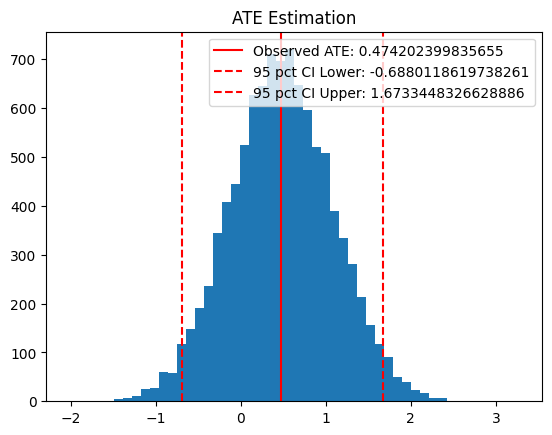

Instantiating dataset ZILLOW into memory
Instantiating dataset IRS_SOCIO into memory
Instantiating dataset NFIP_CLAIMS into memory
Average Treatment Effect, Flooding effects on house prices GA: -4.351814090803494


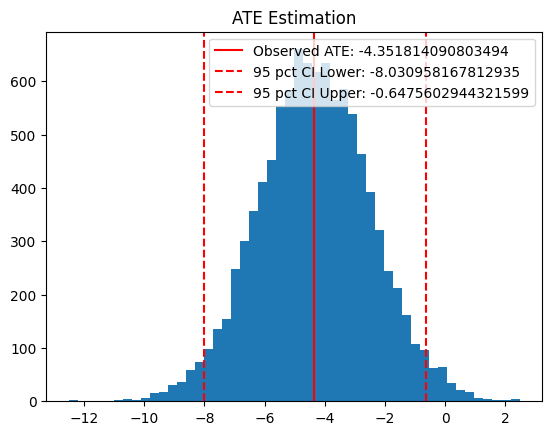

Instantiating dataset ZILLOW into memory
Instantiating dataset IRS_SOCIO into memory
Instantiating dataset NFIP_CLAIMS into memory
Average Treatment Effect, Flooding effects on house prices LA: 0.3902780288489259


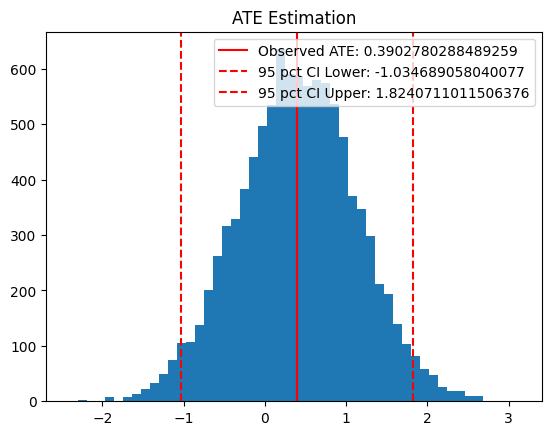

Instantiating dataset ZILLOW into memory
Instantiating dataset IRS_SOCIO into memory
Instantiating dataset NFIP_CLAIMS into memory
Average Treatment Effect, Flooding effects on house prices NC: -4.308555594153397


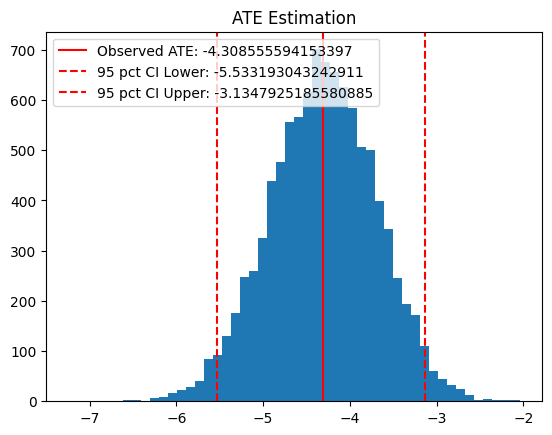

Instantiating dataset ZILLOW into memory
Instantiating dataset IRS_SOCIO into memory
Instantiating dataset NFIP_CLAIMS into memory
Average Treatment Effect, Flooding effects on house prices SC: -1.2490058243277549


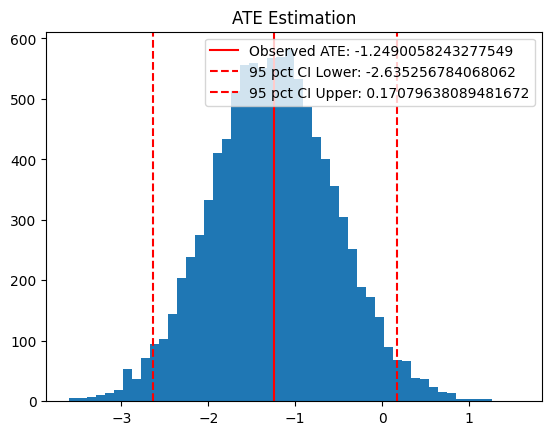

Instantiating dataset ZILLOW into memory
Instantiating dataset IRS_SOCIO into memory
Instantiating dataset NFIP_CLAIMS into memory
Average Treatment Effect, Flooding effects on house prices TX: -2.8273319539576094


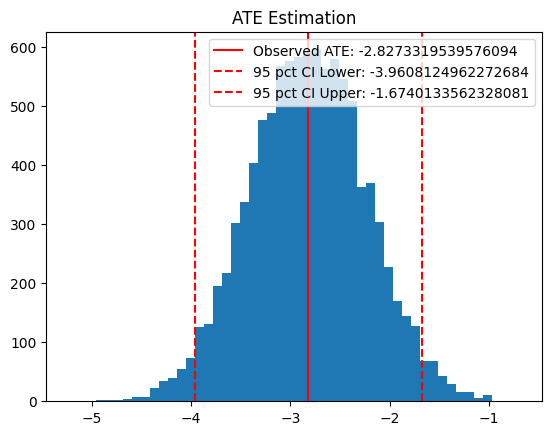

Instantiating dataset ZILLOW into memory
Instantiating dataset IRS_SOCIO into memory
Instantiating dataset NFIP_CLAIMS into memory
Average Treatment Effect, Flooding effects on house prices AL: 1.4600708171258658


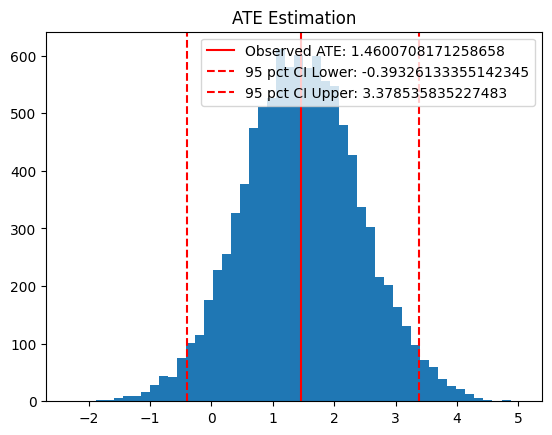

In [20]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
coastal_states = [
    'FL','GA', 'LA', 'NC', 'SC', 'TX','AL'
]
dfacs = np.arange(0,1.0,0.05)
dl = DataLoader() 
res = []
#for dfac in dfacs:
for state in coastal_states:
  causal_analysis = DoubleRobustLearning(dl, state=state, time_window=4)
  causal_analysis.build_features()
#
  outcome_model = RandomForestRegressor(n_estimators=150) 

  tbl=causal_analysis.run_DRL(
    outcome_model = outcome_model, 
    discount_factor = 1.0
    )
  tbl.to_csv(f'../datasets/{state}_climate_causal_effect.csv')
  _, re = causal_analysis.build_treatment_effect_report( 
            plot=True
        ) 
  res.append(re)
        
      
        

In [19]:
dt=pd.DataFrame(res).drop(columns=['Discount Factor'])
dt['ATE Upper Bound'] = dt['ATE Confidence Bounds (95 pct)'].apply(lambda x:x[1])
dt['ATE Lower Bound'] = dt['ATE Confidence Bounds (95 pct)'].apply(lambda x:x[0])
dt[['State', 'ATE Estimate', 'ATE Upper Bound', 'ATE Lower Bound', 'P-value', 'Significant?']].to_csv('../datasets/causal1.csv')


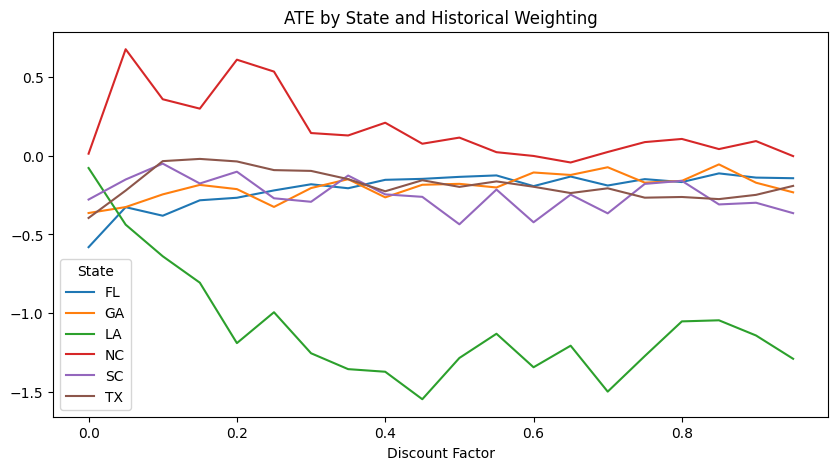

In [377]:
#data=pd.DataFrame(res)
#data['State'] = data['State'].str.replace(', ', '')
#data.pivot(index='Discount Factor', values='ATE Estimate', columns='State').plot(title='ATE by State and Historical Weighting', figsize=(10,5))
#plt.show()

In [378]:
#data.loc[data['Discount Factor'] == 0.9]

,State,Discount Factor,ATE Estimate,ATE Confidence Bounds (95 pct),Significant?
108,FL,0.9,-0.138347,"[-0.40022334717546726, 0.11272281560385586]",False
109,GA,0.9,-0.170920,"[-0.7287909298345958, 0.3769787196528528]",False
110,LA,0.9,-1.143396,"[-2.153364564563162, -0.1627588105968225]",False
111,NC,0.9,0.093965,"[-0.35937729729248696, 0.5361619321873354]",False
112,SC,0.9,-0.298407,"[-1.1655260317803386, 0.5648638752550416]",False
113,TX,0.9,-0.248154,"[-0.5636900949016764, 0.0743318037904211]",False


Model the ATE

use Florida as an example 

Instantiating dataset ZILLOW into memory
Instantiating dataset IRS_SOCIO into memory
Instantiating dataset NFIP_CLAIMS into memory
Average Treatment Effect, Flooding effects on house prices TX: -3.2995698940869396


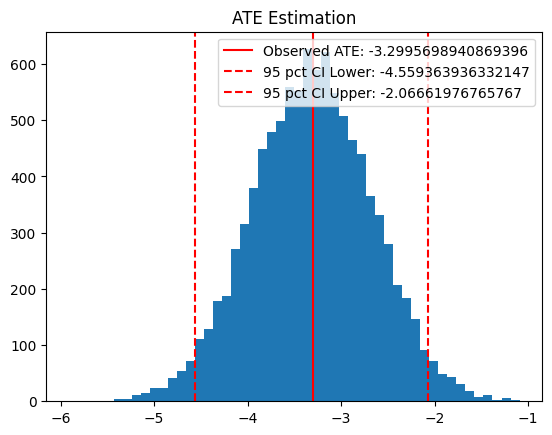

In [559]:
causal_analysis = DoubleRobustLearning(dl, state='TX', time_window=4)
causal_analysis.build_features()

outcome_model = Lasso(alpha=0.05)#RandomForestRegressor(n_estimators=150) 

tbl=causal_analysis.run_DRL(
    outcome_model = outcome_model, 
    discount_factor = 1.0
)
_, re = causal_analysis.build_treatment_effect_report(plot=True)

tbl.to_csv('../datasets/tx_climate_causal_effect.csv')


In [562]:
tbl['treatment_effect_no_corr'].sort_values()


zip
77005   -14.045946
75225   -13.812985
78738   -13.274935
75205   -13.213571
78746   -13.160259
           ...    
78405     5.809621
78076     5.835680
79905     6.037196
77703     6.089726
78040     8.493147
Name: treatment_effect_no_corr, Length: 810, dtype: float64

In [556]:
tbl.groupby(['risk_group'])[['treatment_effect_no_corr']].mean()


,treatment_effect_no_corr
risk_group,
False,-3.553592
True,-2.811226


In [519]:
outcome_model.coef_

array([ 0.        , 66.80063666,  0.        ,  0.        , -0.        ,
       -5.92632051, -0.        , -0.        ,  0.        , -0.        ,
       -1.85149786])

In [501]:
tbl.sort_values(by=['price_shift'])

,1,2,3,4,5,6,elderlyReturns,returnsTotalwSalariesWages,returnsDependentCareCredit,returnsEducationCredit,risk_group,propensity_score,price_shift,y_0,y_1,treatment_effect
zip,,,,,,,,,,,,,,,,
77096,0.289057,0.192705,0.112870,0.074329,0.172058,0.158981,0.265657,0.791466,0.267034,0.050241,True,0.352316,-15.174229,7.752677,-57.322135,-65.074813
78852,0.415127,0.285346,0.141813,0.070047,0.076493,0.011173,0.148260,0.868070,0.330039,0.062312,False,0.365554,-11.422786,-56.964168,14.817127,71.781294
77056,0.196000,0.154400,0.127200,0.088000,0.169600,0.264800,0.301600,0.740000,0.107200,0.042400,True,0.323179,-11.321726,4.566781,-44.596436,-49.163217
77025,0.228925,0.176334,0.132251,0.088940,0.162413,0.211137,0.258314,0.814385,0.188708,0.055684,True,0.320752,-11.258661,6.350018,-48.548068,-54.898086
77079,0.224064,0.157152,0.125844,0.077962,0.148557,0.266421,0.233272,0.812769,0.258441,0.046654,True,0.342849,-11.235255,4.740984,-41.857481,-46.598465
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77011,0.426036,0.306213,0.147929,0.059172,0.053254,0.007396,0.162722,0.829882,0.258876,0.044379,True,0.359029,45.601127,16.233443,98.030985,81.797542
75180,0.393321,0.325603,0.156772,0.070501,0.048237,0.005566,0.128942,0.832096,0.337662,0.055659,False,0.345470,45.968757,99.830924,17.539553,-82.291371
75401,0.354430,0.316456,0.159954,0.078251,0.074799,0.016110,0.172612,0.861910,0.302647,0.044879,False,0.306912,47.641321,117.140028,16.866018,-100.274010


In [390]:
re

{'State': 'SC',
 'Discount Factor': 1.0,
 'ATE Estimate': -0.32915292529400075,
 'ATE Confidence Bounds (95 pct)': [-1.2077672138787323, 0.572311532396286],
 'Significant?': False}

In [557]:
import statsmodels.api as sm
tbl['risk_group'] = tbl['risk_group'].astype(int)
X = sm.add_constant(tbl.iloc[:,:11]).values
Y = tbl['treatment_effect'].to_numpy()

m = sm.OLS(Y,X).fit()
print(m.summary())



                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.153
Model:                            OLS   Adj. R-squared:                  0.142
Method:                 Least Squares   F-statistic:                     14.39
Date:                Thu, 17 Apr 2025   Prob (F-statistic):           1.14e-23
Time:                        20:29:20   Log-Likelihood:                -3429.5
No. Observations:                 810   AIC:                             6881.
Df Residuals:                     799   BIC:                             6933.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -45.6128     21.453     -2.126      0.0

In [382]:
m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.101
Model:                            OLS   Adj. R-squared:                  0.069
Method:                 Least Squares   F-statistic:                     3.100
Date:                Mon, 14 Apr 2025   Prob (F-statistic):           0.000927
Time:                        22:44:23   Log-Likelihood:                -1021.8
No. Observations:                 286   AIC:                             2066.
Df Residuals:                     275   BIC:                             2106.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         52.3913     20.083      2.609      0.010      12.856      91.926
x1            -2.2527     12.124     -0.186      0.853     -26.120      21.614
x2            32.3987     27.418      1.182      0.238     -21.576      86.374
x3           -51.7448     31.847     -1.625      0.105    -114.440      10.950
x4            64.2855     47.181      1.363      0.174     -28.597     157.168
x5             0.4638     30.917      0.015      0.988     -60.400      61.328
x6             9.2408     20.749      0.445      0.656     -31.607      50.088
x7           -37.5970     18.254     -2.060      0.040     -73.532      -1.662
x8           -66.6576     26.175     -2.547      0.011    -118.187     -15.128
x9            13.4941     18.734      0.720      0.472     -23.386      50.374
x10           51.8467     39.010      1.329      0.185     -24.949     128.642
x11           -5.5907      1.253     -4.462      0.000      -8.057      -3.124
==============================================================================
Omnibus:                       11.272   Durbin-Watson:                   1.827
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               22.887
Skew:                           0.097   Prob(JB):                     1.07e-05
Kurtosis:                       4.372   Cond. No.                     4.59e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.86e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Add the raw claims/losses variables into the regression?

In [558]:
risk_vars = causal_analysis.RISK_VARIABLES[['log(totalLosses)',]]
#risk_vars['totalLosses'] = np.exp(risk_vars['log(totalLosses)'])
#risk_vars['totalLosses'] = risk_vars['totalLosses']/risk_vars['totalLosses'].sum()
#risk_vars = risk_vars.drop(columns='log(totalLosses)')
#risk_vars['log(totalLosses)'] = StandardScaler().fit_transform(risk_vars[['log(totalLosses)']])

confounders = tbl.iloc[:,:10]
Y = tbl['treatment_effect'].to_numpy() 
X_tbl = pd.concat((risk_vars, confounders),axis=1).dropna()#.values
X = sm.add_constant(X_tbl)

m_decomposed = sm.OLS(Y,X).fit()
print(m_decomposed.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.150
Model:                            OLS   Adj. R-squared:                  0.140
Method:                 Least Squares   F-statistic:                     14.12
Date:                Thu, 17 Apr 2025   Prob (F-statistic):           3.45e-23
Time:                        20:29:27   Log-Likelihood:                -3430.7
No. Observations:                 810   AIC:                             6883.
Df Residuals:                     799   BIC:                             6935.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

ValueError: aspect must be finite and positive 

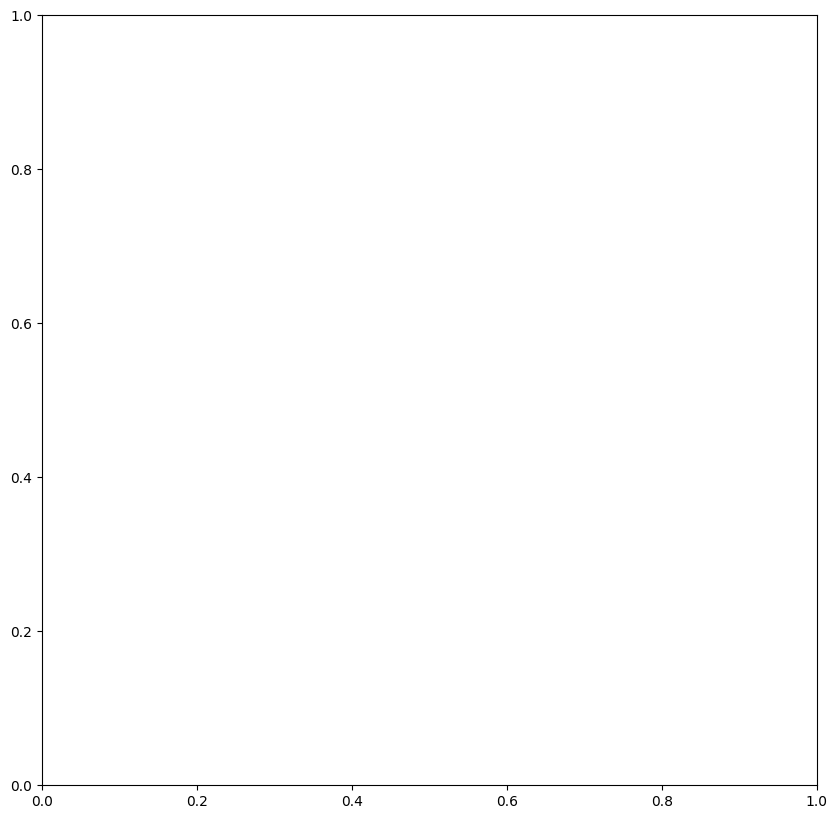

In [445]:
import geopandas as gpd
!pip install mapclassify
import matplotlib.pyplot as plt 

path = '../datasets/State-zip-code-GeoJSON/sc_south_carolina_zip_codes_geo.min.json'
read_file = gpd.read_file(path)[['ZCTA5CE10','geometry']]
template_file = read_file.rename(columns={'ZCTA5CE10':'zip'}).set_index('zip')


geo = gpd.GeoDataFrame(pd.concat((tbl,template_file),axis=1).dropna())
geo.plot(
            column='treatment_effect', 
            legend=True, 
            markersize=0.01,
            figsize=(10,10),
            scheme='Quantiles', 
            legend_kwds={'loc': 'lower left'},
            cmap='BuGn',
        ) 

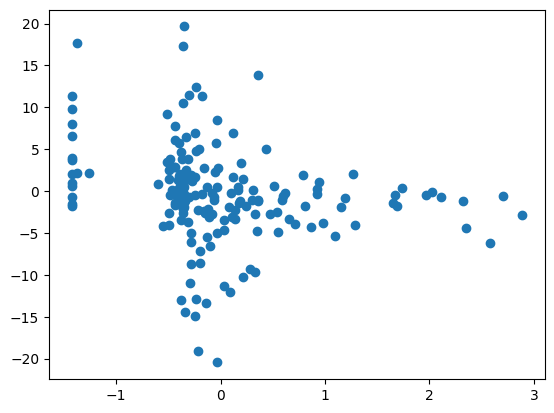

In [401]:
plt.scatter(x=X_tbl['risk_score'],y=Y)

In [305]:
!pip install dbfread
from dbfread import DBF
dbf = DBF('../datasets/State-zip-code-GeoJSON/fl_distance.DBF')
dbff=pd.DataFrame(dbf)[['ZCTA5CE20','NEAR_DIST']].rename(columns={'ZCTA5CE20':'zip'}).set_index('zip')

In [310]:
pd.concat((dbff,tbl),axis=1)

,NEAR_DIST,1,2,3,4,5,6,elderlyReturns,returnsTotalwSalariesWages,returnsDependentCareCredit,returnsEducationCredit,risk_group,propensity_score,price_shift,y_0,y_1,treatment_effect
zip,,,,,,,,,,,,,,,,,
34210,1618.150547,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33010,30622.378756,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33919,2694.392364,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33461,18810.755047,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33605,8029.925193,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71457,NaN,0.387836,0.250249,0.132602,0.072782,0.115653,0.040877,0.253240,0.838485,0.262213,0.055833,1.0,0.396733,0.170380,1.720646,-2.186930,-3.907576
71461,NaN,0.336538,0.336538,0.173077,0.076923,0.076923,0.000000,0.269231,0.846154,0.250000,0.038462,0.0,0.382074,2.927567,4.406102,0.536337,-3.869765
71463,NaN,0.368613,0.262774,0.142336,0.083942,0.120438,0.021898,0.240876,0.850365,0.317518,0.043796,0.0,0.390151,10.381715,7.058420,15.576382,8.517962


In [312]:
tbl.index

Index(['70001', '70002', '70003', '70005', '70006', '70032', '70037', '70039',
       '70043', '70047',
       ...
       '71405', '71409', '71417', '71423', '71446', '71457', '71461', '71463',
       '71467', '71485'],
      dtype='object', name='zip', length=228)

In [313]:
dbff.index

Index(['34210', '33010', '33919', '33461', '33605', '34235', '32622', '34112',
       '33455', '32606',
       ...
       '32347', '33514', '34987', '32181', '32465', '32625', '32071', '33890',
       '32639', '32463'],
      dtype='object', name='zip', length=1013)

In [369]:
len(causal_analysis.IRS_SOCIO['zip'].unique())

279

In [370]:
len(causal_analysis.NFIP_CLAIMS['zip'].unique())

173

In [437]:
data_hp = causal_analysis.ZILLOW.set_index('zip').drop(columns=['Metro','CountyName']).T.bfill()

#((data_hp.iloc[-1]/data_hp.iloc[0])-1)*100

data_hp['year'] = [i.split('-')[0] for i in data_hp.index]
data_grp_yr = data_hp.groupby(['year']).mean()

cpi = causal_analysis.macroeconomic_indicators\
                 .loc[causal_analysis.macroeconomic_indicators['year'].between(2016,2019)][['consumer_price_idx']]\
                 .dropna()\
                 .iloc[1:-1,:]

cpi['year'] = [i.year for i in cpi.index]

cpi_grp = cpi.groupby(['year']).mean()
cpi_idx = cpi_grp.iloc[0]/cpi_grp
cpi_corrected = data_grp_yr.mul(cpi_idx['consumer_price_idx'].to_numpy(),axis=0)

((cpi_corrected.iloc[-1]/cpi_corrected.iloc[0])-1)*100

zip
29072     3.989688
29445    13.400955
29681     6.562830
29485    10.561028
29483    11.442124
           ...    
29320    37.333888
29667    17.169482
29074     0.510586
29333    50.044569
29683    34.407286
Length: 286, dtype: float64

In [436]:
data_grp_yr.mul(cpi_idx['consumer_price_idx'].to_numpy(),axis=0)

zip,29072,29445,29681,29485,29483,29651,29588,29464,29526,29073,...,29351,29175,29065,29658,29377,29320,29667,29074,29333,29683
year,,,,,,,,,,,,,,,,,,,,,
2016,208322.046186,163108.716200,223692.315075,202646.651232,206773.625601,173518.254171,166795.989166,418528.719262,158249.315548,137776.147879,...,NaN,NaN,NaN,NaN,46537.017249,41633.598997,104717.725457,232885.234471,45047.638454,74967.352157
2017,210444.398378,167993.137919,228421.453199,210517.482115,214989.987740,181447.616720,170222.145031,433079.851336,161100.163045,139756.695253,...,NaN,NaN,NaN,NaN,52924.191555,43597.806121,113806.714329,237494.869928,50728.465961,86789.096345
2018,212267.757158,175381.849438,234575.000492,218999.538591,224084.394106,188490.084960,175455.549552,441672.026021,165785.671181,143175.215417,...,NaN,NaN,NaN,NaN,57689.692965,48273.654041,120656.387438,225671.874030,57078.714361,97799.088151
2019,216633.446613,184966.842156,238372.861517,224048.221179,230432.920176,195151.848584,181236.360427,439687.482368,171072.966623,149299.543321,...,NaN,NaN,NaN,NaN,66850.517061,57177.040018,122697.216400,234074.314701,67591.535147,100761.583183


In [434]:
cpi_idx

,consumer_price_idx
year,
2016,1.000000
2017,0.980003
2018,0.956670
2019,0.940628
